In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%gui qt

import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(10,5))

import pathlib
import tifffile
import h5py

import napari
from napari.utils.notebook_display import nbscreenshot

import seaborn as sns


from dask_image.imread import imread
import dask.array as da

from scipy import ndimage as ndi

import skimage.segmentation as segmentation 
import skimage.filters as filters

from skimage.feature import peak_local_max
from skimage.measure import label, regionprops, regionprops_table
from skimage import morphology

#from skimage.future import graph

# Postprocessing Segmentation
Ilastik outputs a probability mask that assigns a probability for each pixel that it either belongs to foreground (cell) or background.
We now need to convert this to a proper segmentation.

> **Exercise**  
>  
> Think about the steps needed to convert a probability map to a segmentation.

## Import and visualize data
First we import visualize the raw data using Napari.

In [2]:
#Set the path to the folder that contains project data
root = pathlib.Path('/Users/simonvanvliet/switchdrive/Biozentrum/Data/Images2Insight/processed_data/project0/')

In [4]:
im_path = root/'proj0_pos0_preproc-rg.tif' #path to image
im_stack = tifffile.imread(im_path) #load image into memory
#im_stack = imread(im_path) #load image with dask-image for out of memory processing 

#setup napari viewer, with 2 channel image
viewer = napari.view_image(im_stack,
            channel_axis=1,
            name=["red", "green"],
            colormap=["yellow", "blue"],)
napari.run()

Next we load the segmentation data exported by Ilastik.

In [5]:
seg_path = root/'proj0_pos0_preproc-rg_Probabilities.h5' #path to Ilastik output
seg_data = h5py.File(seg_path, 'r')
print('keys = ', list(seg_data.keys()))


keys =  ['exported_data']


`h5py.File=()` loads a dictionary, which contains a single key `exported_data`.  
This contains the Ilastik segmentation probability output as an array of shape (t,c,y,x).  
We only need the probability that a pixel belongs to the foreground class (= cells) and add this layer to the viewer.

In [6]:
fg_idx = 0 #index of foreground seg
seg_cell = seg_data['exported_data'][:,fg_idx,:,:] #extract forground (= cell) layer
#add probability layer to Napari Viewer
prop_layer = viewer.add_image(seg_cell, name='probability',colormap='gray')

> **Exercise** 
>   
> Check the segmentation quality. How well did it work? Are there frames with big problems?
>   
> If needed, you can go back to Ilastik and add extra training points in problem areas (check with Tutor).

## Filtering data
As first step probability maps are often processed using a Gaussian blur filter, of a small (~1 pixel) size, to ensure that the probability maps are locally smooth. We will use scikit image filters for this. 

In [11]:
sigma = 1 #size of Gaussion kernel to use 
#apply filter, use channel_axis to make sure we do not filter accross the time (0) axis 
seg_cell_sm = filters.gaussian(seg_cell, sigma, channel_axis=0) 
#add to viewer
prop_layer_sm = viewer.add_image(seg_cell_sm, name='probability smoothed',colormap='gray')

## Threshold data
[Thresholding](https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29) is used to convert continues probability maps into binary label images. It is a first step in segmenting objects. A threshold value determines the intensity value separating foreground pixels from background pixels. Foregound pixels are pixels brighter than the threshold value, background pixels are darker.

Different thresholding algorithms produce different results. [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) and [Li's minimum cross entropy threshold](https://scikit-image.org/docs/dev/auto_examples/developers/plot_threshold_li.html) are two common algorithms. Below, we use Otsu. 


> **Exercise**
> 
> Try to find a good threshold value for the segmentation  
> 
> Hint: you can find all available options in the skimage API: [`skimage.filters.threshold_[method_name]`](https://scikit-image.org/docs/stable/api/skimage.filters.html) 

In [14]:
threshold_value =  filters.threshold_otsu(seg_cell_sm)
print('Threshold value = ', threshold_value)
bin_mask = seg_cell_sm > threshold_value
mask_layer = viewer.add_image(bin_mask, name='otsu_treshold',colormap='gray')

Threshold value =  0.5019531


Another option is to interactively change the threshold and pick a value that looks nice.  
This can easily be done using Napari. To not blow out your laptop's memory we use [Dask](https://docs.dask.org/en/stable/) for out-of-memory computation. Don't worry about what this means right now, we will get back to this later. 

In [15]:
# covert segdata into dask array
seg_cell_da = da.from_array(seg_cell_sm, chunks=(1, seg_cell.shape[1], seg_cell.shape[2]))

#create array with all threshold values to rry, here we use 0,0.01,0.02,...,1
thresholds_to_try = np.linspace(0,1,101)

#apply treshold
all_thresholds = [seg_cell_da>t for t in thresholds_to_try]

#convert to stack
threshold_stack = da.stack(all_thresholds, axis=0)

#add to viewer
mask_layer_int = viewer.add_image(threshold_stack, name='binary mask int',colormap='gray')


In the Napari viewer you will now have a new layer `binary mask int`, which shows you the result of the interactive thresholding, you can change the threshold value by moving the new slider (channel 0).

> **Exercise** 
>  
> Move the slider to find a good threshold value. How does it compare to the one calculated by the algorithms above? 
> 
> Hint: the slider position shows the index in the `thresholds_to_try`

Note: if at any time you want to store the current view shown in the Napari viewer, then you can use `nbscreenshot(viewer)`.

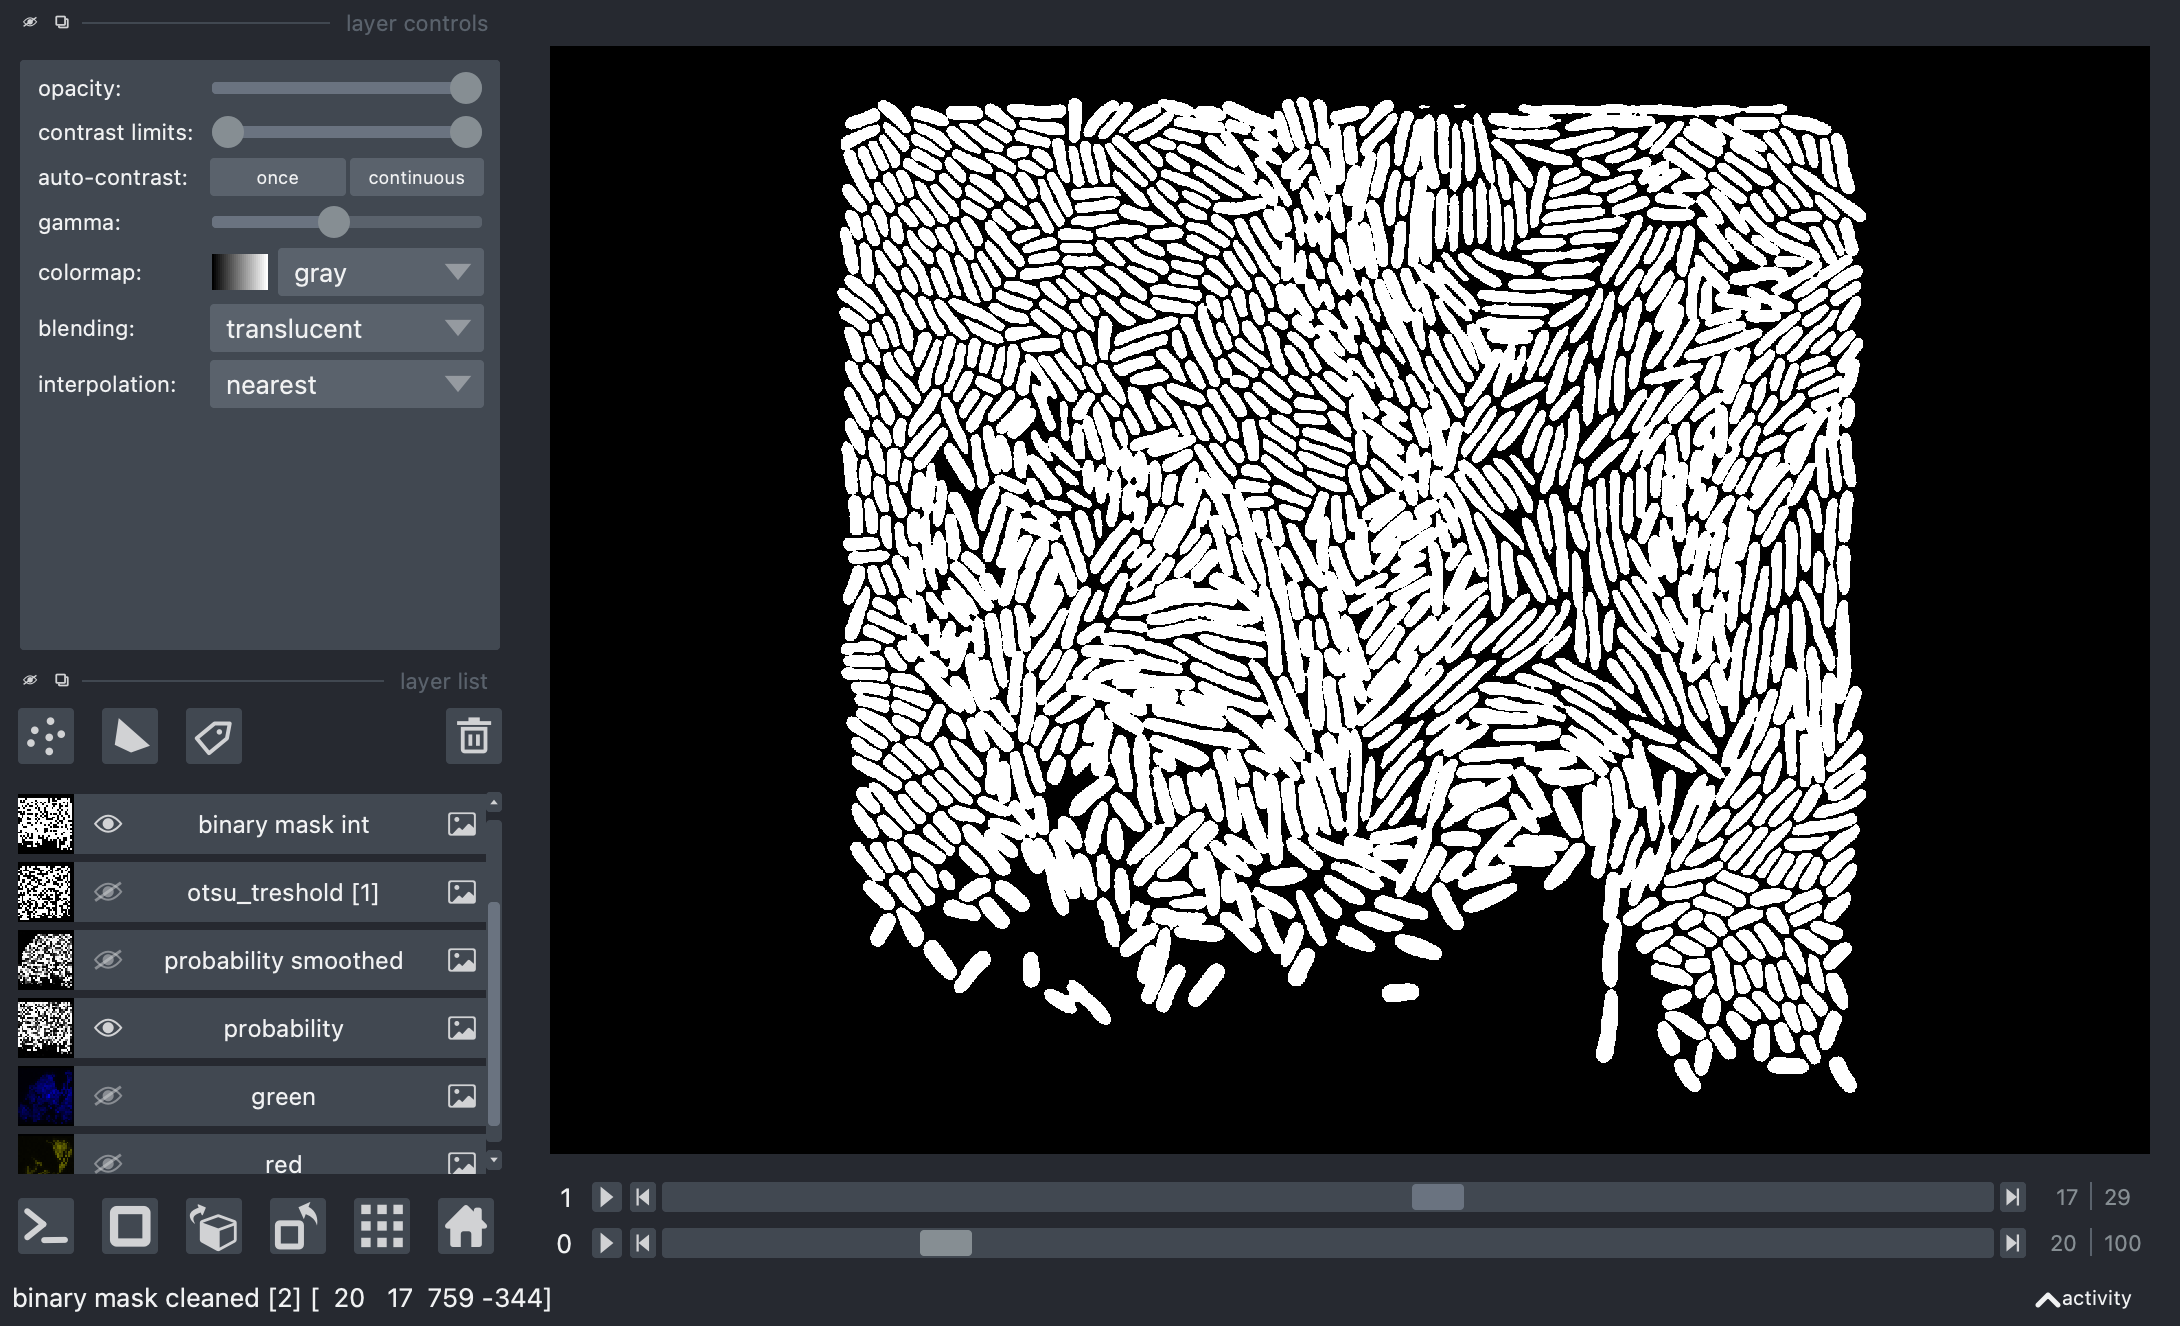

In [27]:
nbscreenshot(viewer)

> **Exercise** 
> 
> Now it is time to choose a final threshold value. Enter the value you have chosen below.

In [21]:
#choose your favorite method or enter a manually chosen value
final_threshold = filters.threshold_otsu(seg_cell_sm) 

#threshold and add to viewer
bin_mask = seg_cell_sm > threshold_value
mask_layer_final = viewer.add_image(bin_mask, name='final binary mask',colormap='gray')

We can now remove the interactive threshold layer from the viewer.

In [47]:
viewer.layers.remove("binary mask int")

## Morphological operations

[Mathematical morphology](https://en.wikipedia.org/wiki/Mathematical_morphology) operations and structuring elements are defined in `skimage.morphology`.

Functions operating on [connected components](https://en.wikipedia.org/wiki/Connected_space) can remove small undesired elements while preserving larger shapes.

`skimage.morphology.remove_small_holes` fills holes and `skimage.morphology.remove_small_objects` removes bright regions. Both functions accept a size parameter, which is the minimum size (in pixels) of accepted holes or objects.

`skimage.morphology` only works on 2D/3D image data, not on time stacks, we thus have to loop over time.

> **Exercise**
>
> Try finding good values for `max_hole_size` and `min_cell_size`


In [24]:
max_hole_size = 10 # maximum area of holes that will be filled (in pixels)
min_cell_size = 150 # minimum area of objects to keep (in pixels)

bin_mask_clean = np.empty_like(bin_mask) #initialize empty array of right size for ou
for t, image in enumerate(bin_mask):
    holes_removed = morphology.remove_small_holes(image, max_hole_size)
    bin_mask_clean[t,:,:] = morphology.remove_small_objects(holes_removed, min_cell_size)

mask_layer_clean = viewer.add_image(bin_mask_clean, name='binary mask cleaned',colormap='gray')

## Segmentation

Now we are ready to label the connected components of this image. This means that each object will be assigned a unique number. For this we use the `skimage.measure.labels()` function. To add labels to Napari, we can use the `add_label()` function.

You can change the colors assigned to cells, using the shuffle button in upper left corner. 

> **Exercise**
> 
> Inspect the segmentation. Do you find any problems? Think about what we need to do next.

In [45]:
#again we will need to loop over the time axis manually 
label_im = np.empty(bin_mask_clean.shape, dtype=np.int32) #initialize empty array of right size for ou
for t, mask in enumerate(bin_mask_clean):
    label_im[t,:,:] = label(mask.astype(int))
    
label_layer = viewer.add_labels(label_im, opacity=0.5)

We can see that tightly packed cells connected in the binary image are assigned the same label.

A better segmentation would assign different labels to different cells. 

Typically we use [watershed segmentation](https://en.wikipedia.org/wiki/Watershed_%28image_processing%29) for this purpose. We place *markers* at the centre of each object, and these labels are expanded until they meet an edge or an adjacent marker.

The trick, then, is how to find these markers. It can be quite challenging to find markers with the right location. A slight amount of noise in the image can result in very wrong point locations. Here is a common approach: find the distance from the object boundaries, then place points at the maximal distance.

We first use the `ndi.distance_transform_edt` function to calculate the distance to edge for each pixel in each object.

In [63]:
#again we will need to loop over the time axis manually 
dist_transform = np.empty(bin_mask_clean.shape) #initialize empty array of right size for ou

for t, mask in enumerate(bin_mask_clean):
    dist_transform[t,:,:] = ndi.distance_transform_edt(mask)
    
dist_layer = viewer.add_image(dist_transform, name='distance transform',colormap='viridis')   

Next we find the local maxima using the `peak_local_max` function. This takes one useful input argument, the `min_distance` between peaks with witch you can control the number of local maxima.

Ideally each cell should have a single local maxima, but finding the right settings can be hard.

> **Exercise**
> 
> Try different values of `min_distance` to try to find a good number of seeding points
> 
> Hint: you can also try to smooth the distance map, using `filters.gaussian()` (see above)


In [100]:
min_distance = 8

markers_list = np.empty((3,0))
markers_max_dist = np.zeros(seg_cell_sm.shape, dtype=np.int32)

#initialize empty array of right size for ou
for t, dist_map in enumerate(dist_transform):
    #dist_map = filters.gaussian(dist_map, 2) 
    peak_idx = peak_local_max(dist_map, min_distance=min_distance)
    peak_idx_3d = np.insert(peak_idx.T,0,t,axis=0)
    markers_list = np.concatenate((markers_list,peak_idx_3d),axis=1)
    
    peak_mask = np.zeros_like(dist_map, dtype=bool)
    peak_mask[tuple(peak_idx.T)] = True
    markers_max_dist[t,:,:] = label(peak_mask)
    
    

point_layer = viewer.add_points(
    np.transpose(markers_list),
    name='center points',
    size=4,
    n_dimensional=False)

As you notice it can be quite a pain to find the right settings, especially for rod shape objects.

Instead of using the maxima of the distance map to find the seed points, we can use another approach. We can use a very high threshold for the probability map to find regions where we are very sure that they are cells. Then we can use these regions as seed points for the watershed.

In [101]:
center_threshold = 0.90

markers_max_prop = np.empty(seg_cell_sm.shape, dtype=np.int32) #initialize empty array of right size

for t, prob in enumerate(seg_cell_sm):
    center_seg = prob > center_threshold
    markers_max_prop[t,:,:] = label(center_seg)
    
centre_layer = viewer.add_labels(markers_max_prop, name='cell centre areas')   

Once we have the center points we can further segment the image using `skimage.segmentation.watershed`

> **Exercise**
> 
> Try running the watershed with the different markers `markers_max_dist` or `markers_max_prop` and evaluate the quality

In [145]:
#choose which markers to use 
markers = markers_max_prop
#markers = markers_max_dist


label_sep = np.empty(seg_cell_sm.shape, dtype=np.int32) #initialize empty array of right size for ou
for t, dist_map in enumerate(dist_transform):
    label_sep[t,:,:] = segmentation.watershed(-dist_map, markers=markers[t,:,:], mask=bin_mask_clean[t,:,:])   

watershed_layer = viewer.add_labels(label_sep, name='after watershed')   

The watershed should have cut clusters of cells apart, but maybe also cut cells in half which should not be split. There are several things you could do here to improve things

- Improve segmentation
  - The better quality the input data has, the easier and better the post-processing will be 
  - In many cases the fastest solution will be to return to Ilastik and add some training points in problem regions
- Choose appropriate method to find seeds
  - For rod shape objects, the max probability often works better then the distance to edge
- Optimize method to find seeds
  - e.g. you could further tweak the procedure by smoothing, eroding masks etc.
- Use 3 classes to segment your image (cell centre / cell edge / background)
  - You can then calculate distance transform on cell edge data
  - More over you can use `skimage.future.graph.rag.rag_boundary` and `skimage.future.graph.merge_hierarchical()` to merge objects back together 

For time reasons we will skip these steps now, but we can come back to them at the end of the course if time allows it. 

After watershed, we have better disambiguation between internal cells!

## Making measurements

Once we have defined our objects, we can make measurements on them using `skimage.measure.regionprops` and the new `skimage.measure.regionprops_table`. These measurements include features such as area or volume, bounding boxes, and intensity statistics.

Before measuring objects, it helps to clear objects from the image border. Measurements should only be collected for objects entirely contained in the image.

In [136]:
interior_labels = np.empty_like(label_sep) #initialize empty array of right size for ou
for t, label_im in enumerate(label_sep):
    interior_labels[t, :, :] = segmentation.clear_border(label_im)
    
int_lab = viewer.add_labels(interior_labels)

`skimage.measure.regionprops` automatically measures many labeled image features. Optionally, an `intensity_image` can be supplied and intensity features are extracted per object. Note that color axis needs to be at the end!

In [144]:
reg_props = []

for label_im, image in zip(label_sep, im_stack):
    #region props need color channel to be at end
    image = np.moveaxis(image, 0, -1)
    reg_props.append(regionprops(label_im, intensity_image=image))
    
    
print(len(reg_props))
print(len(reg_props[0]))
print(reg_props[0][0])
reg_props[0][0].area   

Above we made a list containing the region properties for each time point.

You can extract the properties for each time point using `reg_props[t]`. This returns another list containing all cells at that time point. To see the properties of a single cell we can use `rep_props[t][c]`. This return a skimage region properties object, which is basically a dictionary. We can thus extract a property using `rep_props[t][c].[property_name]`.

> **Exercise** 
> 
> Look at the scikit-image documentation for [`regionprops`](https://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=regionprops#skimage.measure.regionprops) to see what kind of properties are extracted

Note: scikit-image 0.18 adds support for [passing custom functions](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) for region properties as `extra_properties`.

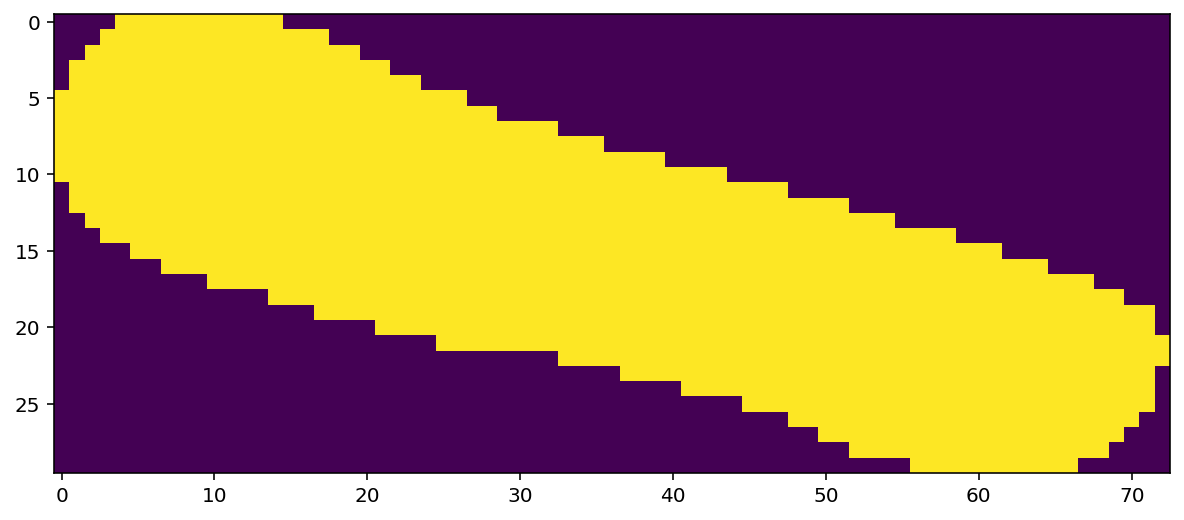

In [210]:
#explore some cell properties
reg_props[0][0].intensity_mean
fig, axs = plt.subplots(figsize=(10,5))
axs.imshow(reg_props[0][0].image.T)

`regionprops` returns a huge amount of info, but navigating it is a bit cumbersome. 

Instead you can use [`regionprops_table`](https://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=regionprops#skimage.measure.regionprops), which returns a dictionary of columns compatible with creating a pandas dataframe of properties of the data.

Here we will first look at a single frame:

In [160]:
label_im = label_sep[0,:,:]    
image = np.moveaxis(im_stack[0,:,:], 0, -1)    
    
info_table = pd.DataFrame(
        regionprops_table(
        label_im,
        intensity_image=image,
        properties=['label', 'area', 'centroid', 
                    'axis_major_length', 'axis_minor_length',
                    'mean_intensity'] 
    )
).set_index('label')

With `head()` we can have a look at the Panda's data frame (similar to R data frame or Matlab structure)and with `columns` we can get info on the column (= variable name).

In [166]:
print(info_table.columns)
info_table.head()


Index(['area', 'centroid-0', 'centroid-1', 'axis_major_length',
       'axis_minor_length', 'mean_intensity-0', 'mean_intensity-1'],
      dtype='object')


,area,centroid-0,centroid-1,axis_major_length,axis_minor_length,mean_intensity-0,mean_intensity-1
label,,,,,,,
1,1091,72.237397,1419.961503,82.601963,17.573765,151.267644,1170.185151
2,1067,63.807873,1462.074977,81.046941,17.450496,138.029991,841.459231
3,1006,83.154076,977.138171,62.506376,20.974787,157.956262,697.413519
4,820,86.803659,1401.153659,65.806558,16.234708,175.639024,1026.901220
5,2099,87.528823,1121.439257,165.637375,19.468668,943.131015,158.116722


Just as in R we can add new columns, for example we could calculate the aspect ratio, or add a constant value to e.g. indicate the frame nr.:

In [169]:
info_table["aspect_ratio"] = info_table['axis_major_length']/info_table['axis_minor_length']
info_table["frame"] = 0
info_table.head()

,area,centroid-0,centroid-1,axis_major_length,axis_minor_length,mean_intensity-0,mean_intensity-1,aspect_ratio,frame
label,,,,,,,,,
1,1091,72.237397,1419.961503,82.601963,17.573765,151.267644,1170.185151,4.700300,0
2,1067,63.807873,1462.074977,81.046941,17.450496,138.029991,841.459231,4.644392,0
3,1006,83.154076,977.138171,62.506376,20.974787,157.956262,697.413519,2.980072,0
4,820,86.803659,1401.153659,65.806558,16.234708,175.639024,1026.901220,4.053449,0
5,2099,87.528823,1121.439257,165.637375,19.468668,943.131015,158.116722,8.507894,0


So far we only analyzed a single frame, now let's combine them all. To do this it is helpful to define a function that processes a single time point and than call this for each time point. We the use `pandas.concat` to combine all time points into a single data frame.

In [171]:
  
def extract_prop_slice(t, label_im, image):
    #region props need color channel to be at end
    image = np.moveaxis(image, 0, -1)

    df = pd.DataFrame(
        regionprops_table(
        label_im,
        intensity_image=image,
        properties=['label', 'area', 'centroid', 
                    'axis_major_length', 'axis_minor_length',
                    'mean_intensity'] 
        )
    )
    #add the time index
    df["frame"] = t
    return df

#here we call the function for each time point.    
df_list = [extract_prop_slice(t, label, image) for t, (label, image) in enumerate(zip(label_sep, im_stack))]
info_table_all = pd.concat(df_list)
info_table_all.head()


,label,area,centroid-0,centroid-1,axis_major_length,axis_minor_length,mean_intensity-0,mean_intensity-1,frame
0,1,1091,72.237397,1419.961503,82.601963,17.573765,151.267644,1170.185151,0
1,2,1067,63.807873,1462.074977,81.046941,17.450496,138.029991,841.459231,0
2,3,1006,83.154076,977.138171,62.506376,20.974787,157.956262,697.413519,0
3,4,820,86.803659,1401.153659,65.806558,16.234708,175.639024,1026.901220,0
4,5,2099,87.528823,1121.439257,165.637375,19.468668,943.131015,158.116722,0


Now let's analyze some data. We will first look at how the number of cells changes over time, and plot using the Pandas build in plot function (based on Matplotlib)

<AxesSubplot:xlabel='frame', ylabel='# of cells'>

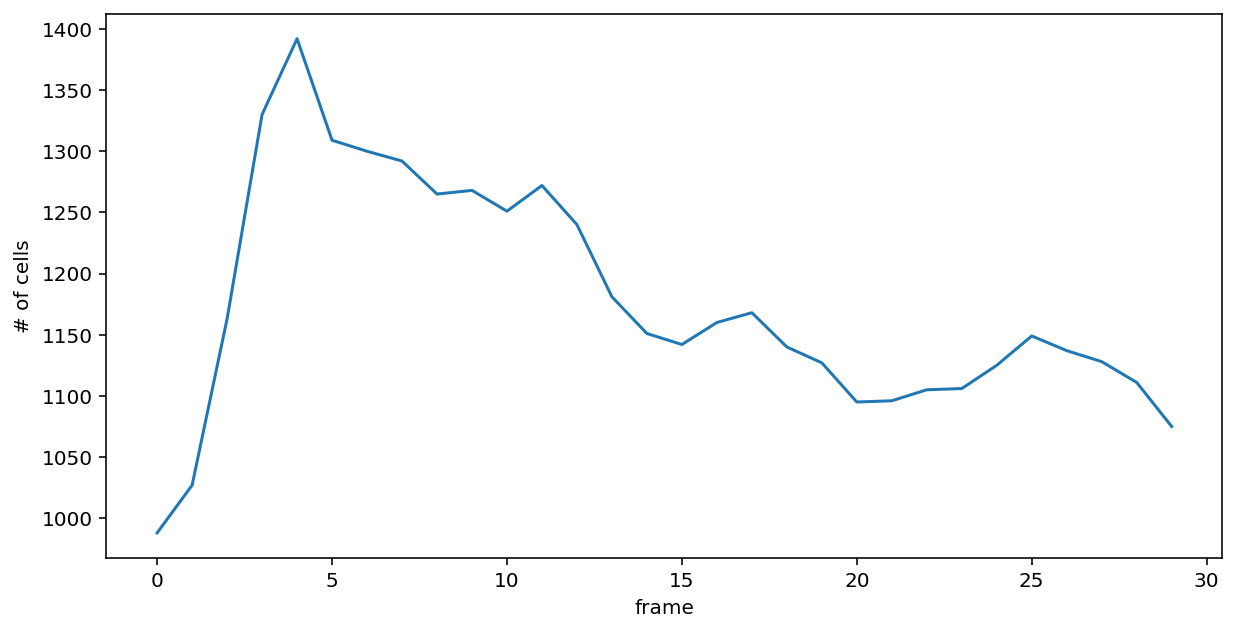

In [207]:
cell_num_t = info_table_all.groupby('frame').size()
cell_num_t.plot(xlabel='frame',ylabel='# of cells',figsize=(10,5))

Next let's calculate some average properties and see how they change over time, and we will plot the results with [Matplotlib](https://matplotlib.org/stable/index.html)

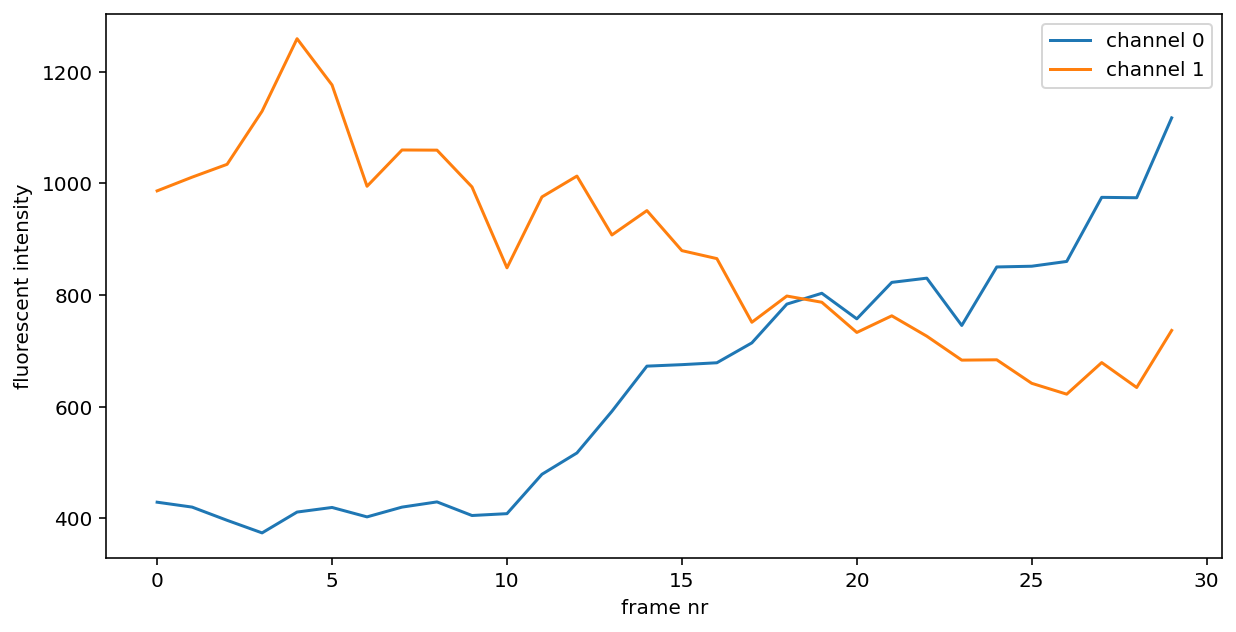

In [206]:
av_prop = info_table_all.groupby('frame').mean()
av_prop['frame'] = av_prop.index
av_prop.head()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(av_prop['frame'],av_prop['mean_intensity-0'],label='channel 0')
ax.plot(av_prop['frame'],av_prop['mean_intensity-1'],label='channel 1')
ax.set_xlabel('frame nr')
ax.set_ylabel('fluorescent intensity')
ax.legend()

For a more R-like experience with plotting, you can use [seaborn](https://seaborn.pydata.org/index.html):

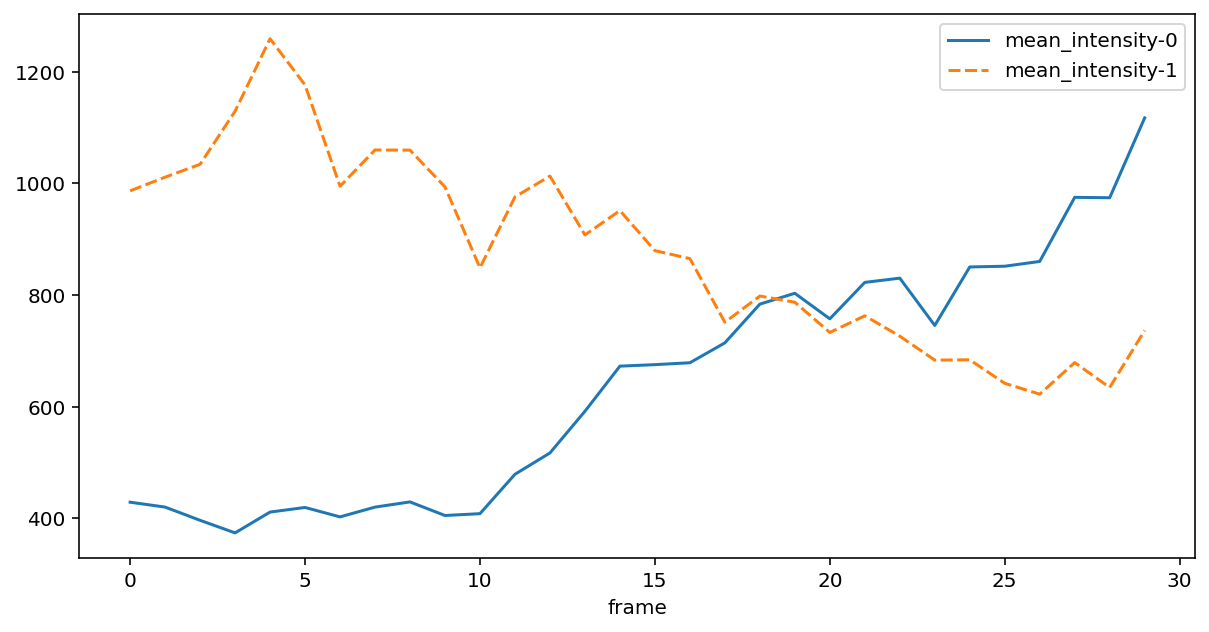

In [214]:
av_fluor = av_prop[["mean_intensity-0", "mean_intensity-1"]] 
sns.lineplot(data=av_fluor);

Similarly we can look at distributions and scatter plots:

<AxesSubplot:xlabel='mean_intensity-0', ylabel='mean_intensity-1'>

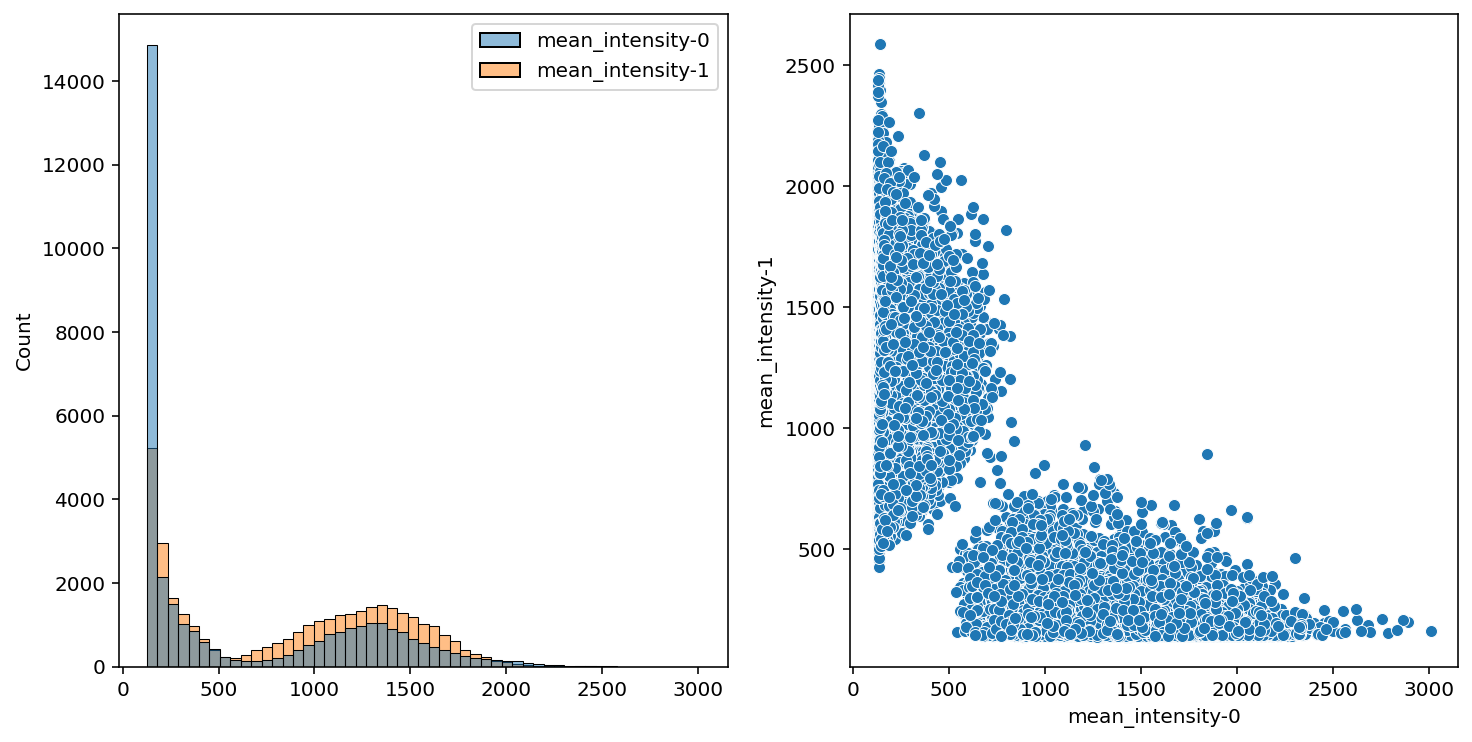

In [219]:
all_fluor = info_table_all[["mean_intensity-0", "mean_intensity-1"]] #create dataframe with only fluorescent values
fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.histplot(ax=axs[0], data=all_fluor)
sns.scatterplot(ax=axs[1], data=all_fluor, x="mean_intensity-0", y="mean_intensity-1")

## Exercise
We are interested in the dynamics of the community, and would like to know how the fraction of red cells changes over time. Try to come up with a wat to calculate this.

Hints:
- Think about how you can tell red and green cells apart in a reliable way
- Classify cells as either red or green
- Calculate the fraction of red cells over time

In [ ]:
#enter code here

In [234]:
data = info_table_all["mean_intensity-0"]

clip=[1E-3, 0.999]
lims = np.quantile(data, clip)


data = (data - lims[0]) / (lims[1] - lims[0])

np.max(data)

1.29832777082007

### Solution 1
Use normalization and fluorescent ratio

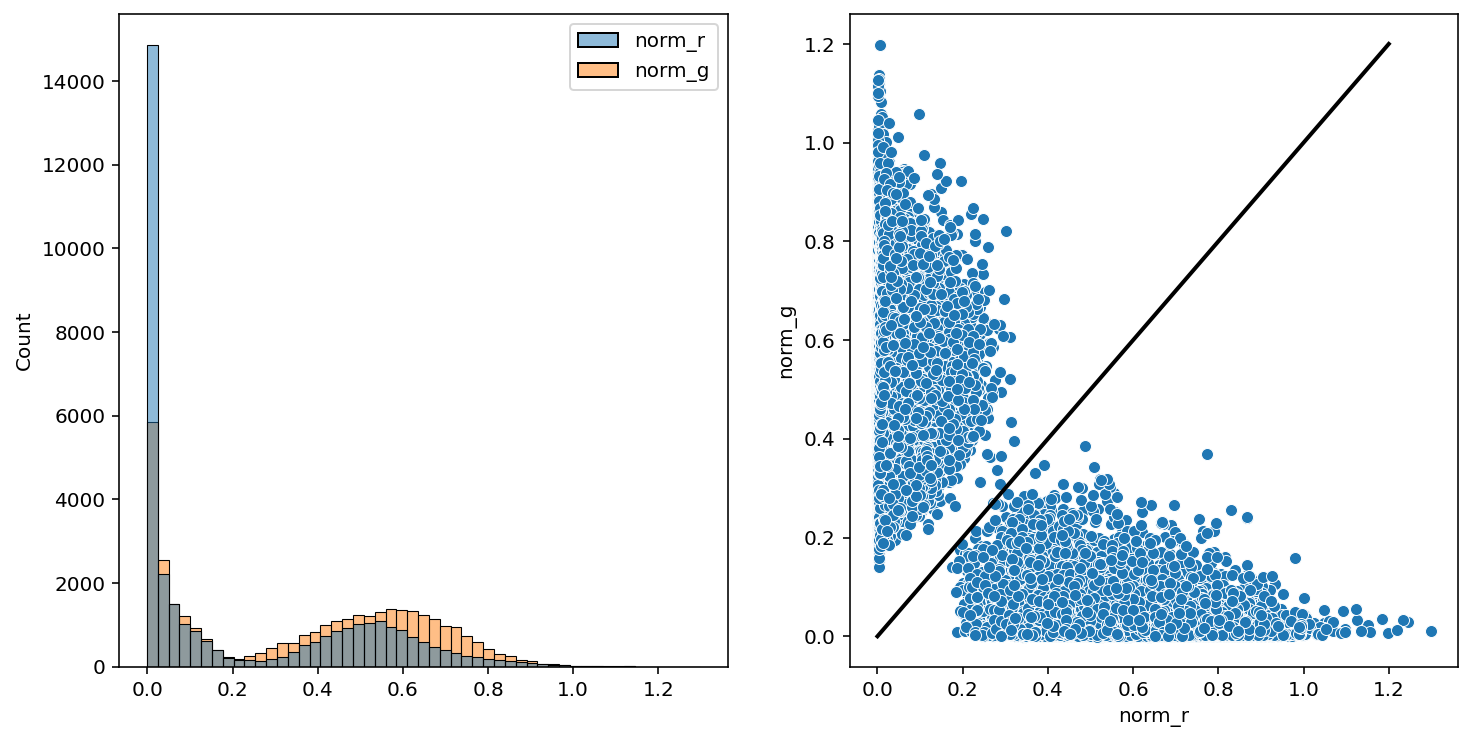

In [306]:
def norm_data(data, clip=[1E-3, 0.999], bounded=False):
    lims = np.quantile(data, clip)
    
    data_clipped = (data - lims[0]) / (lims[1] - lims[0])
        
    if bounded:
        data_clipped[data_clipped<0] = 0
        data_clipped[data_clipped>1] = 1
                
    return data_clipped
    
norm_red = norm_data(info_table_all["mean_intensity-0"])
norm_green = norm_data(info_table_all["mean_intensity-1"])
norm_fluor = pd.concat([norm_red,norm_green], keys=['norm_r','norm_g'], axis=1) 

fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.histplot(ax=axs[0], data=norm_fluor)
sns.scatterplot(ax=axs[1], data=norm_fluor, x="norm_r", y="norm_g")

axs[1].plot([0, 1.2], [0, 1.2], linewidth=2, color='k')
plt.show()


<AxesSubplot:xlabel='frame'>

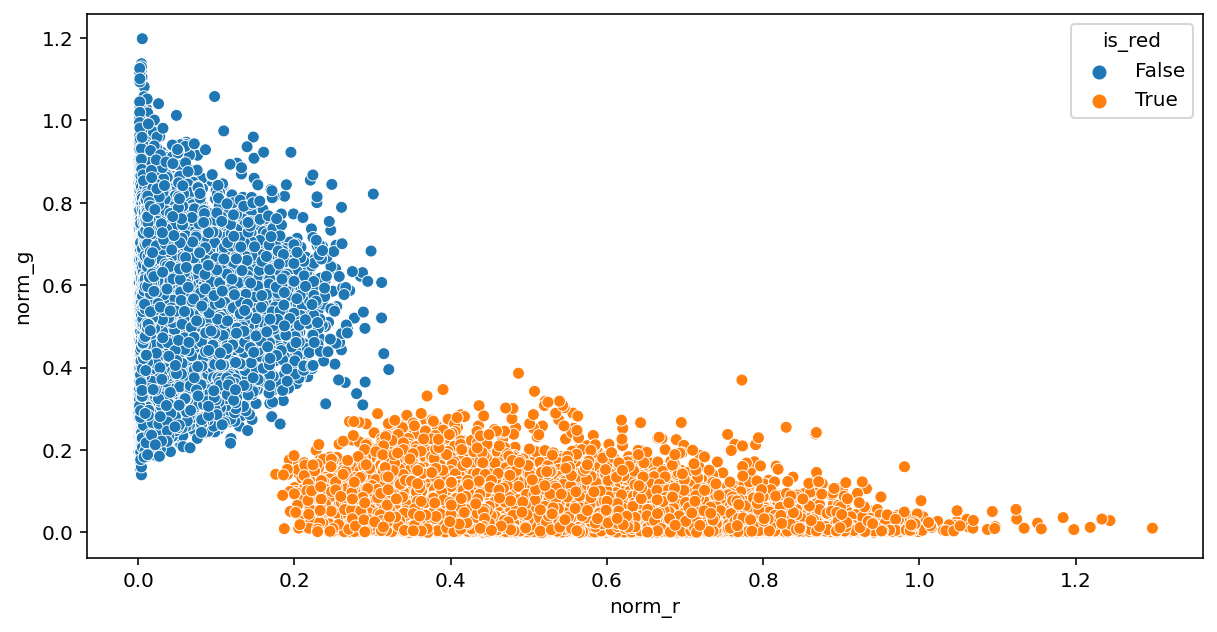

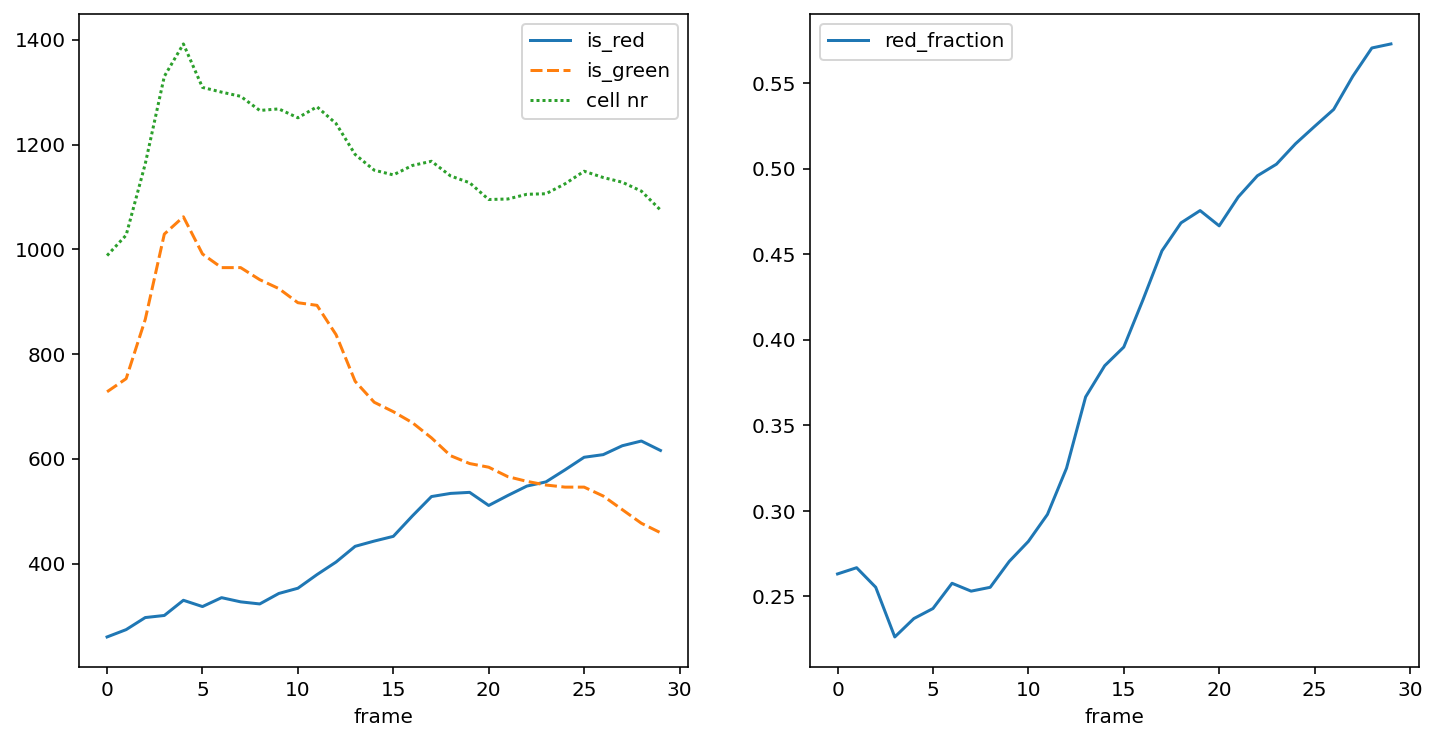

In [307]:
norm_fluor['is_red'] = norm_red > norm_green
norm_fluor['is_green'] = norm_red <= norm_green
norm_fluor['cell nr'] = 1
norm_fluor['frame'] = info_table_all['frame'] 

sns.scatterplot(x=norm_fluor['norm_r'], y=norm_fluor['norm_g'], hue=norm_fluor['is_red'])


cell_type_t = norm_fluor.groupby('frame').sum()
cell_type_t['red_fraction'] = cell_type_t['is_red'] / cell_type_t['cell nr']

fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.lineplot(ax=axs[0], data=cell_type_t[['is_red','is_green','cell nr']])
sns.lineplot(ax=axs[1], data=cell_type_t[['red_fraction']])

### Solution 2
Use clustering

<AxesSubplot:>

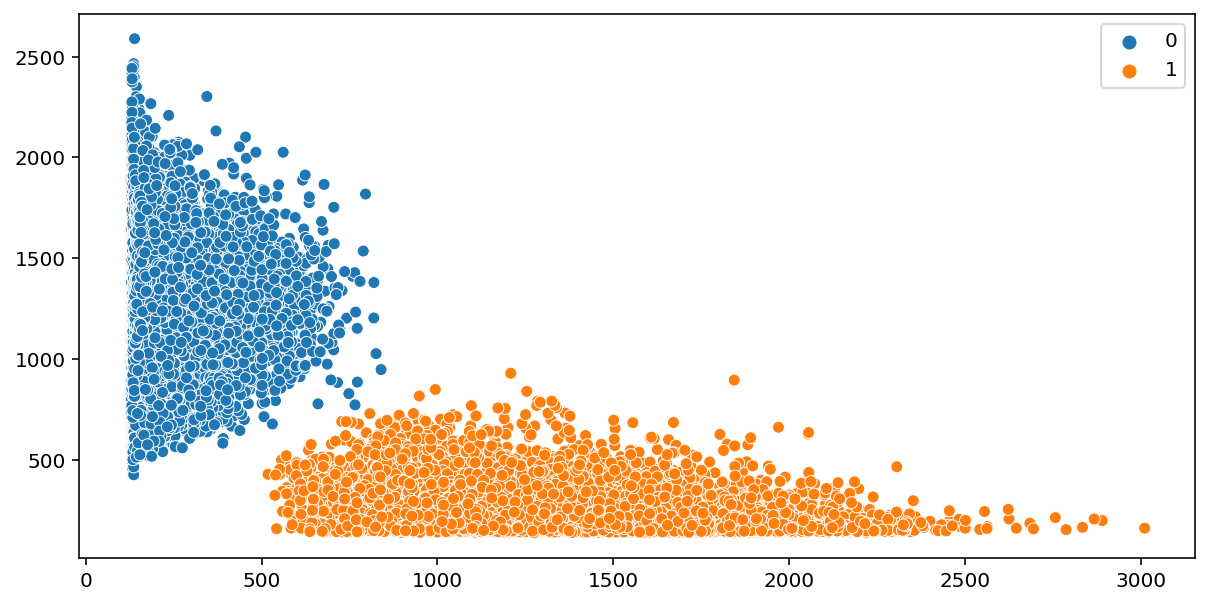

In [303]:
from sklearn.cluster import KMeans 

red = info_table_all["mean_intensity-0"]
green = info_table_all["mean_intensity-1"]
norm_fluor = pd.concat([red,green], keys=['r','g'], axis=1) 


norm_fluor_np = norm_fluor[['r','g']].to_numpy()
kmeans_fit = KMeans(n_clusters=2, random_state=0).fit(norm_fluor_np)
cell_class = kmeans_fit.labels_

sns.scatterplot(x=norm_fluor_np[:,0], y=norm_fluor_np[:,1], hue=cell_class)

<AxesSubplot:xlabel='frame'>

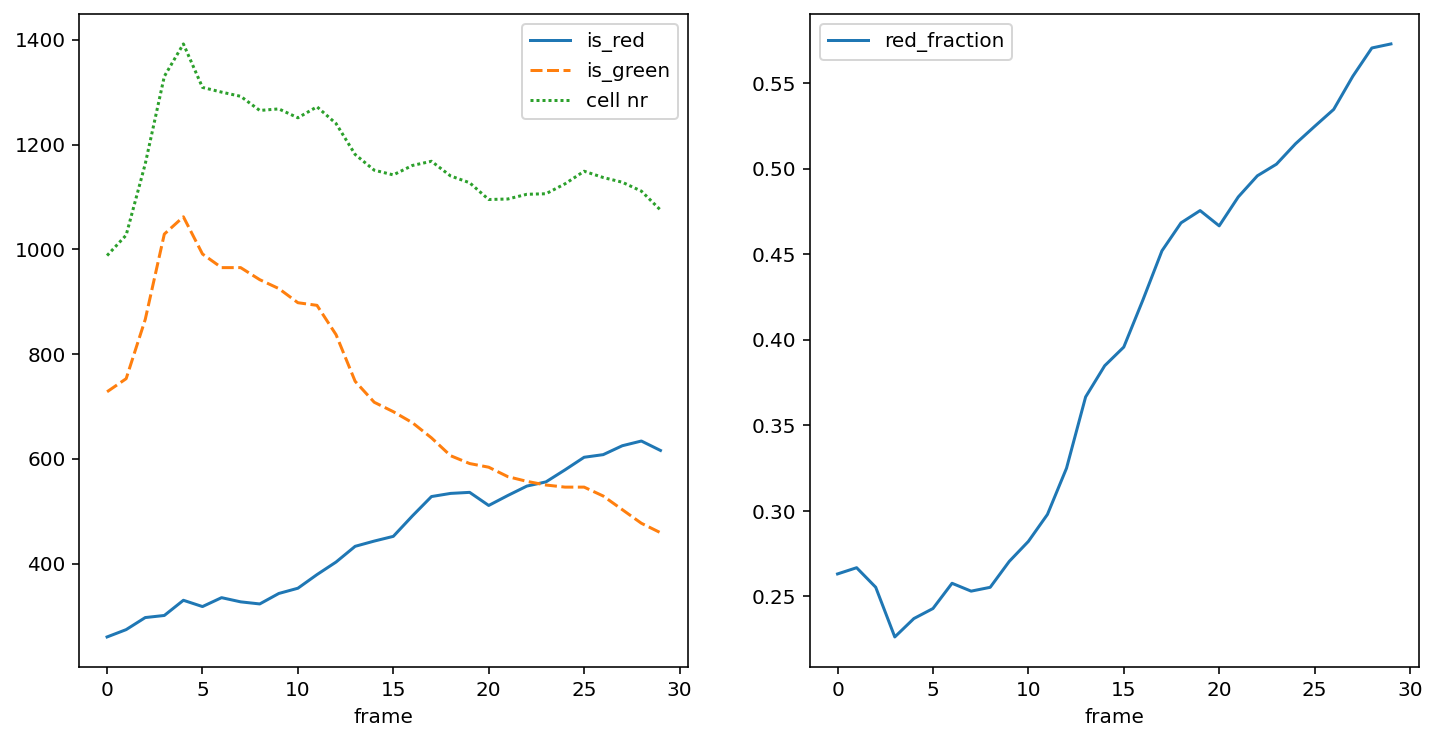

In [304]:
norm_fluor['is_red'] = cell_class
norm_fluor['is_green'] = np.logical_not(cell_class)
norm_fluor['cell nr'] = 1
norm_fluor['frame'] = info_table_all['frame'] 

cell_type_t2 = norm_fluor.groupby('frame').sum()
cell_type_t2['red_fraction'] = cell_type_t2['is_red'] / cell_type_t2['cell nr']

fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.lineplot(ax=axs[0], data=cell_type_t2[['is_red','is_green','cell nr']])
sns.lineplot(ax=axs[1], data=cell_type_t2[['red_fraction']])



## To Do (For Simon)
- Add Notebook on out-of-memory processing with Dask and with proper processing functions
- Add Notebook on fluorescent image correction (shading, background, etc)
- Add Notebook on checking classification by making new label images 
- Add Notebook on pre-processing with Python
- Check adding deconvolution to start of workflow

 